Notebook purpose:

- Explore from when on MDB has access to account histories of at least 12 months.

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/mdb_eval")
import src.data.aggregators as agg
import src.data.make_data as md
import src.data.selectors as sl
import src.helpers.data as hd
import src.helpers.io as io

fs = s3fs.S3FileSystem(profile="3di")

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2

## Data

Load 1 percent sample of transaction data (`X11` is sample containing all users with IDs ending in "11")

In [3]:
dft = hd.read_txn_data("X11")
hd.inspect(dft)

Time for read_txn_data                 : 3.22 minutes
shape: (6,653,551, 35), users: 2734


,date,user_id,amount,desc,merchant,tag_group,tag_spend,user_registration_date,account_created,account_id,account_last_refreshed,account_provider,account_type,birth_year,data_warehouse_date_created,data_warehouse_date_last_updated,id,is_debit,is_female,is_sa_flow,is_salary_pmt,is_urban,latest_balance,lsoa,merchant_business_line,msoa,postcode,region_name,salary_range,tag,tag_auto,tag_manual,tag_up,updated_flag,ym
0,2012-01-03,11,69.750000,david lloyd <mdbremoved>,david lloyd,spend,sports,2010-06-30,1900-01-01,303733,2014-07-24 11:05:00,lloyds,current,1954.0,2014-07-18,2017-08-15,80656,True,0.0,False,False,1.0,150.029999,e01015428,david lloyd,e02003207,bh15 4,south west,10k to 20k,hobbies,gym membership,no tag,gym membership,u,2012-01
1,2012-01-03,11,96.400002,sky digital xxxxxxxxxx9317,sky,spend,"entertainment, tv, media",2010-06-30,1900-01-01,303733,2014-07-24 11:05:00,lloyds,current,1954.0,2014-07-18,2017-08-15,80654,True,0.0,False,False,1.0,150.029999,e01015428,sky,e02003207,bh15 4,south west,10k to 20k,services,"entertainment, tv, media",no tag,media bundle,u,2012-01


Create account-level dataset

In [16]:
def account_level_data(df):
    aggs = {
        "user_id": "first",
        "account_type": "first",
        "account_created": "first",
        "account_provider": "first",
    }

    return (
        df.groupby(["account_id", "ym"], as_index=False)
        .agg(aggs)
        .assign(
            account_created=lambda df: df.account_created.dt.to_period("m"),
            mts_to_creation=lambda df: df.account_created.view(int) - df.ym.view(int),
        )
    )


dfa = account_level_data(dft)
dfa.head(3)

,account_id,ym,user_id,account_type,account_created,account_provider,mts_to_creation
0,1014,2014-05,67211,current,2014-06,barclays,1
1,1014,2014-06,67211,current,2014-06,barclays,0
2,1014,2014-07,67211,current,2014-06,barclays,-1


## Max available account history by bank and year of account creation

- Below suggests that all major banks start providing historical data of at least 12 months for at least some of their savings and current accounts from April 2017 onwards. 
- Assuming that banks provid that same historical data for all accounts of the same type, we can conclude that we can observe at least 12 months of historical data for all savings and current accounts added after March 2017.

In [36]:
def n_largest_banks(df, n):
    """Returns list with names of n largest banks in df."""
    return (
        df.groupby("account_id")
        .account_provider.first()
        .value_counts()[:n]
        .index.to_list()
    )


assert n_largest_banks(dfa, 1) == ["natwest bank"]


def max_history_by_provider_and_year(df, n=20):
    """
    Returns for savings and current accounts the max length of
    historical data (in months) available by bank and year of
    account creation for n largest banks.
    """
    largest_banks = n_largest_banks(df, n)

    mask = (
        df.account_provider.isin(largest_banks)
        & df.account_type.isin(["savings", "current"])
        & df.account_created.dt.year.ge(2012)
    )

    return (
        df[mask]
        .groupby(["account_provider", df.account_created, "account_type"])
        .mts_to_creation.describe()
        .loc[:, "max"]
        .unstack()
        .loc[:, ["savings", "current"]]
    )


df_history = max_history_by_provider_and_year(dfa)
df_history.head(5)

account_type                            savings  current
account_provider       account_created                  
bank of scotland (bos) 2012-09              NaN      0.0
                       2012-10            -52.0    -52.0
                       2012-11              3.0      3.0
                       2012-12              3.0      3.0
                       2013-01              NaN      0.0

Check from when on there are at least 12 months of history

In [50]:
df_history.groupby("account_created").describe().loc[
    :, [("savings", "max"), ("current", "max")]
].loc["2016":]

account_type,savings,current
,max,max
account_created,,
2016-01,3.0,3.0
2016-02,3.0,3.0
2016-03,3.0,3.0
2016-04,3.0,3.0
2016-05,3.0,3.0
2016-06,3.0,3.0
2016-07,3.0,3.0
2016-08,3.0,4.0


Visual exploration

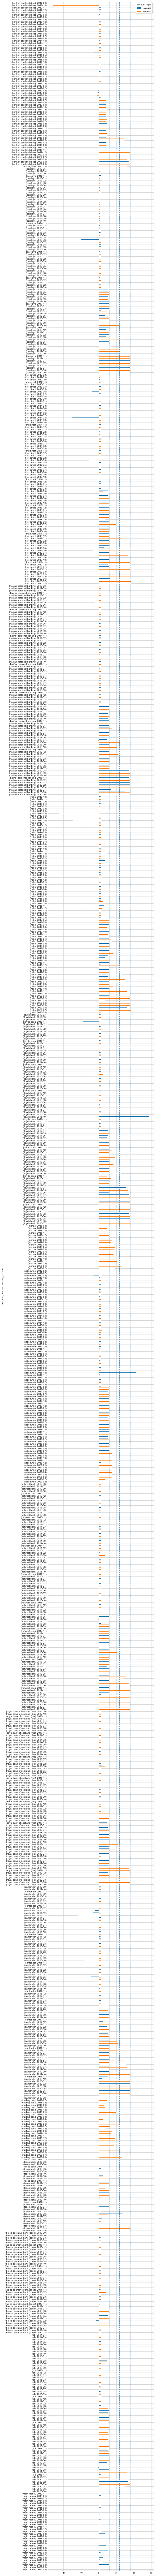

In [38]:
def plot_history(data, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    data.plot(kind="barh", ax=ax)
    ax.invert_yaxis()
    ax.axvline(12, linestyle="--")
    ax.axvline(24, linestyle="--")
    ax.axvline(36, linestyle="--")


plot_history(df_history, figsize=(8, 200))